Here we will build an convolutional neural network to predict the CIFAR-10 data.
The script provided will download and unzip the CIFAR-10 data.  Then it will start training a CNN from scratch.  You should see similar output at the end to the following two graphs.

![Loss and Accuracy](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/08_Convolutional_Neural_Networks/images/03_cnn2_loss_acc.png?raw=true)

Here we see the training loss (left) and the test batch accuracy (right).


In [1]:
import os
import sys
import tarfile
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from six.moves import urllib
ops.reset_default_graph()

#change dir
abspath = os.path.abspath(__name__)
dirname = os.path.dirname(abspath)
os.chdir(dirname)
# Start a graph session
sess = tf.Session()

# Set model parameters
batch_size = 128
data_dir = 'cifar10'
output_every = 50
generations = 5000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'

cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'

# Exponential Learning Rate Decay Params
learning_rate = 0.1
lr_decay = 0.1
num_gens_to_wait = 250.

# Extract model parameters
image_vec_length = image_height * image_width * num_channels
record_length = 1 + image_vec_length  # ( + 1 for the 0-9 label)

In [2]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# Check if file exists, otherwise download it
data_file = os.path.join(data_dir,'cifar-10-binary.tar.gz')
if os.path.isfile(data_file):
    pass
else:
    # Download file
    def progress(block_num,block_size,total_size):
        progress_info = [cifar10_url,float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
    filepath,_ = urllib.request.urlretrieve(cifar10_url,data_file,progress)
    # Extract file
    tarfile.open(filepath,'r:gz').extractall(data_dir)

In [3]:
# Define CIFAR reader
'''
tf.FixedLengthRecordReader是读取固定长度字节数信息(针对bin文件使用FixedLengthRecordReader读取比较合适)，
结果表明下次调用时会接着上次读取的位置继续读取文件，而不会从头开始读取。
'''
def read_cifar_files(filename_queue,distort_image=True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key,record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string,tf.uint8)
    image_label = tf.cast(tf.slice(record_bytes,[0],[1]),tf.int32)
    # Extract image
    image_extracted = tf.reshape(tf.slice(record_bytes,[1],[image_vec_length]),[num_channels,image_width,image_height])
    # Reshape image
    image_uint8 = tf.transpose(image_extracted,[1,2,0]) #e.g [2,1,0]，就把输入张量的第三维度和第一维度交换。
    reshaped_image = tf.cast(image_uint8, tf.float32)
    # Randomly Crop image
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,crop_width,crop_height)
    if distort_image:
        # Randomly flip the image horizontally, change the brightness and contrast
        final_image = tf.image.flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image, max_delta=63)
        final_image = tf.image.random_contrast(final_image, lower=0.2, upper=1.8)
    # Normalize whitening
    final_image = tf.image.per_image_standardization(final_image) #f.image.per_image_whitening() 更名为 tf.image.per_image_standardization()
    return (final_image,image_label)

# Create a CIFAR image pipeline from reader
def input_pipline(batch_size,train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir,extract_folder,'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir,extract_folder,'test_batch.bin')]
    filename_queue = tf.train.string_input_producer(files)
    image,label = read_cifar_files(filename_queue)
     # min_after_dequeue defines how big a buffer we will randomly sample
    #   from -- bigger means better shuffling but slower start up and more
    #   memory used.
    # capacity must be larger than min_after_dequeue and the amount larger
    #   determines the maximum we will prefetch.  Recommendation:
    #   min_after_dequeue + (num_threads + a small safety margin) * batch_size
    min_after_dequeue = 5000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch,label_batch = tf.train.shuffle_batch([image,label],
                                                      batch_size=batch_size,
                                                      capacity=capacity,
                                                      min_after_dequeue=min_after_dequeue)
    return (example_batch, label_batch)

# Define the model architecture, this will return logits from images
def cifar_cnn_model(input_images,batch_size,train_logical=True):
    def truncated_normal_var(name,shape,dtype):
        return (tf.get_variable(name=name,shape=shape,dtype=dtype,initializer=tf.truncated_normal_initializer(0.05)))
    def zero_var(name,shape,dtype):
        return(tf.get_variable(name=name,shape=shape,dtype=dtype,initializer=tf.constant_initializer(0.0)))
    
    # First Convolutional Layer
    with tf.variable_scope('conv1') as scope:
        #Conv_kernel is 5x5 for all 3 colors and we will create 64 features
        conv1_kernel = truncated_normal_var(name='conv_kernel1',shape=[5,5,3,64],dtype=tf.float32)
        # We convolve across the image with a stride size of 1
        conv1 = tf.nn.conv2d(input=input_images,filter=conv1_kernel,strides=[1,1,1,1],padding="SAME")
        # Initialize and add the bias term
        conv1_bias = zero_var(name="conv_bias1",shape=[64],dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1,conv1_bias)
        #relu element wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
            
    # Max Pooling
    pool1 = tf.nn.max_pool(relu_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME",name="pool_layer1")
    # Local Response Normalization (parameters from paper)
    # paper: http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
    norm1 = tf.nn.lrn(pool1,depth_radius=5,bias=2.0,alpha=1e-3,beta=0.75,name="norm1")
    
    # Second Convolutional Layer
    with tf.variable_scope("conv2") as scope:
        # Conv kernel is 5x5, across all prior 64 features and we create 64 more features
        conv2_kernel = truncated_normal_var(name="conv_kernel2",shape=[5,5,64,64],dtype=tf.float32)
        # Convolve filter across prior output with stride size of 1
        conv2 = tf.nn.conv2d(norm1,conv2_kernel,strides=[1,1,1,1],padding="SAME")
        # Initialize and add the bias
        conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        # ReLU element wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
    #max pooling
    pool2 = tf.nn.max_pool(relu_conv2,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME",name="pool_layer2")
    # Local Response Normalization (parameters from paper)
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    # Reshape output into a single matrix for multiplication for the fully connected layers
    reshaped_output = tf.reshape(norm2,[batch_size,-1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    # First Fully Connected Layer
    with tf.variable_scope("full1") as scope:
        # Fully connected layer will have 384 outputs.
        full_weight1 = truncated_normal_var(name="full_mult1",shape=[reshaped_dim,384],dtype=tf.float32)
        full_bias1 = zero_var(name="full_bias1",shape=[384],dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output,full_weight1),full_bias1))
        
    # Second Fully Connected Layer
    with tf.variable_scope("full2") as scope:
        # Second fully connected layer has 192 outputs.
        full_weight2 = truncated_normal_var(name="full_mult2",shape=[384,192],dtype=tf.float32)
        full_bias2 = zero_var(name="full_bias2",shape=[192],dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1,full_weight2),full_bias2))
        
    # Final Fully Connected Layer -> 10 categories for output (num_targets)
    with tf.variable_scope("full3") as scope:
        # Final fully connected layer has 10 (num_targets) outputs.
        full_weight3 = truncated_normal_var(name="full_mult3",shape=[192,num_targets],dtype=tf.float32)
        full_bias3 = zero_var(name="full_bias3",shape=[num_targets],dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2,full_weight3),full_bias3)
        
    return (final_output)

# Loss function
def cifar_loss(logits,targets):
    # Get rid of extra dimensions and cast targets into integers
    targets = tf.squeeze(tf.cast(targets,tf.int32))
    # Calculate cross entropy from logits and targets
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=targets)
    cross_entropy_mean = tf.reduce_mean(cross_entropy,name="cross_entropy")
    return (cross_entropy_mean)
# help(tf.train.exponential_decay)
# Train step
def train_step(loss_values,generation_num):
    # Our learning rate is an exponential decay after we wait a fair number of generations
    model_learning_rate = tf.train.exponential_decay(learning_rate=learning_rate,
                                                     global_step=generation_num,
                                                     decay_steps=num_gens_to_wait,
                                                    decay_rate=lr_decay,staircase=True)
    # Create optimizer
    my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    train_step = my_optimizer.minimize(loss_values)
    return (train_step)

# Create optimizer
def accuracy_of_batch(logits,targets):
    # Make sure targets are integers and drop extra dimensions
    targets = tf.squeeze(tf.cast(targets,tf.int32))
    # Get predicted values by finding which logit is the greatest
    batch_predictions = tf.cast(tf.argmax(logits,1),tf.int32)
    # Check if they are equal across the batch
    predicted_correctly = tf.equal(batch_predictions,targets)
    # Average the 1's and 0's (True's and False's) across the batch size
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly,tf.float32))
    
    return (accuracy)

# Get data
print('Getting/Transforming Data.')
# Initialize the data pipeline
images,targets = input_pipline(batch_size=batch_size,train_logical=True)
# Get batch test images and targets from pipline
test_images,test_targets = input_pipline(batch_size=batch_size,train_logical=False)
# Declare Model
print('Creating the CIFAR10 Model.')

with tf.variable_scope('model_definition') as scope:
    # Declare the training network model
    model_output = cifar_cnn_model(images,batch_size)
    # This is very important!!!  We must set the scope to REUSE the variables,
    #  otherwise, when we set the test network model, it will create new random
    #  variables.  Otherwise we get random evaluations on the test batches.
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images,batch_size)

# Declare loss function
print('Declare Loss Function.')
loss = cifar_loss(model_output,targets)
# Create accuracy function
test_accuracy = accuracy_of_batch(test_output,test_targets)
# Create training operations
print('Creating the Training Operation.')
generation_num = tf.Variable(0,trainable=False)
train_op = train_step(loss_values=loss,generation_num=generation_num)
# Initialize Variables
print('Initializing the Variables.')
init = tf.global_variables_initializer()
sess.run(init)
# Initialize queue (This queue will feed into the model, so no placeholders necessary)
tf.train.start_queue_runners(sess=sess)


Getting/Transforming Data.
Creating the CIFAR10 Model.
Declare Loss Function.
Creating the Training Operation.
Initializing the Variables.


[<Thread(Thread-6, started daemon 7964)>,
 <Thread(Thread-7, started daemon 11740)>,
 <Thread(Thread-8, started daemon 11856)>,
 <Thread(Thread-9, started daemon 5660)>]

In [4]:
# Train CIFAR Model
print('Starting Training')
train_loss_vec = []
test_accuracy_vec = []
for i in range(generations):
    _,loss_value = sess.run([train_op,loss])
    if (i+1) % output_every == 0:
        train_loss_vec.append(loss_value)
        output = 'Generation {}:loss={:.5f}'.format((i + 1),loss_value)
        print(output)
        
    if (i + 1) % eval_every == 0:
        [temp_acc] = sess.run([test_accuracy])
        test_accuracy_vec.append(temp_acc)
        acc_output = "Test Accuracy:{:.2f}%".format(100. * temp_acc)
        print(acc_output)

# Print loss and accuracy
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0,generations,eval_every)
output_indices = range(0,generations,output_every)

print(eval_indices,output_indices)

Starting Training
Generation 50:loss=2.30736
Generation 100:loss=2.30353
Generation 150:loss=2.30360
Generation 200:loss=2.30364
Generation 250:loss=2.30363
Generation 300:loss=2.30379
Generation 350:loss=2.30401
Generation 400:loss=2.30204
Generation 450:loss=2.30212
Generation 500:loss=2.30101
Test Accuracy:10.16%
Generation 550:loss=2.30198
Generation 600:loss=2.30145
Generation 650:loss=2.30261
Generation 700:loss=2.30330
Generation 750:loss=2.30220
Generation 800:loss=2.30324
Generation 850:loss=2.30368
Generation 900:loss=2.30367
Generation 950:loss=2.30117
Generation 1000:loss=2.30448
Test Accuracy:12.50%
Generation 1050:loss=2.30205
Generation 1100:loss=2.30352
Generation 1150:loss=2.30272
Generation 1200:loss=2.30223
Generation 1250:loss=2.30317
Generation 1300:loss=2.30233
Generation 1350:loss=2.30216
Generation 1400:loss=2.30241
Generation 1450:loss=2.30395
Generation 1500:loss=2.30344
Test Accuracy:8.59%
Generation 1550:loss=2.30258
Generation 1600:loss=2.30470
Generation 1

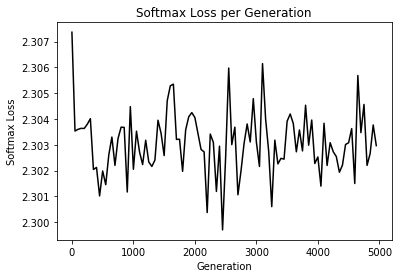

In [5]:
# Plot loss over time
plt.plot(output_indices,train_loss_vec,'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()


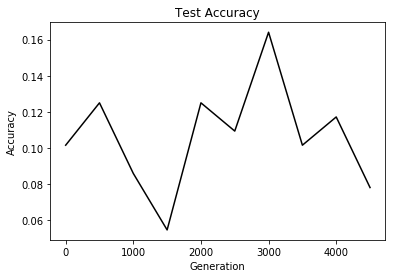

In [6]:
# Plot accuracy over time
plt.plot(eval_indices, test_accuracy_vec, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()